# Crude oil price prediction using LSTM

### importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras
import pickle

# Importing dataset
1.Since data is in form of excel file we have to use pandas read_excel to load the data
2.After loading it is important to check the complete information of data as it can indication many of the hidden infomation such as null values in a column or a row
3.Check whether any null values are there or not. if it is present then following can be done, a.Imputing data using Imputation method in sklearn b.Filling NaN values with mean, median and mode using fillna() method
4.Describe data --> which can give statistical analysis

In [2]:
data=pd.read_excel(r"Crude Oil Prices Daily.xlsx")

In [3]:
data.head()

Date  Closing Value
0 1986-01-02          25.56
1 1986-01-03          26.00
2 1986-01-06          26.53
3 1986-01-07          25.85
4 1986-01-08          25.87

In [4]:
data.tail()

Date  Closing Value
8218 2018-07-03          74.19
8219 2018-07-04            NaN
8220 2018-07-05          73.05
8221 2018-07-06          73.78
8222 2018-07-09          73.93

In [5]:
data.describe()

Closing Value
count    8216.000000
mean       43.492139
std        29.616804
min        10.250000
25%        19.577500
50%        29.610000
75%        63.402500
max       145.310000

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8223 entries, 0 to 8222
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           8223 non-null   datetime64[ns]
 1   Closing Value  8216 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 128.6 KB


# Data Preprocessing

## Checking or null values

In [7]:
data.isnull().any()

Date             False
Closing Value     True
dtype: bool

In [8]:
data.isnull().sum()

Date             0
Closing Value    7
dtype: int64

In [9]:
data.dropna(axis=0,inplace=True)

In [10]:
data.isnull().sum()

Date             0
Closing Value    0
dtype: int64

In [11]:
data.shape

(8216, 2)

### Selecting Closing value column for prediction

In [12]:
data_oil=data.reset_index()['Closing Value']

In [13]:
data_oil

0       25.56
1       26.00
2       26.53
3       25.85
4       25.87
        ...  
8211    73.89
8212    74.19
8213    73.05
8214    73.78
8215    73.93
Name: Closing Value, Length: 8216, dtype: float64

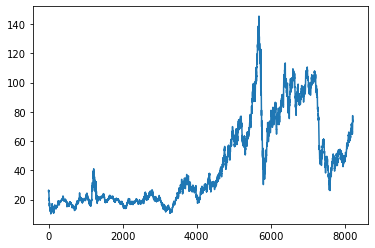

In [14]:
plt.plot(data_oil)

In [15]:
print(data_oil)

0       25.56
1       26.00
2       26.53
3       25.85
4       25.87
        ...  
8211    73.89
8212    74.19
8213    73.05
8214    73.78
8215    73.93
Name: Closing Value, Length: 8216, dtype: float64


In [16]:
closing_values = np.reshape(data['Closing Value'].values,(-1,1))

### splitting dataset into train and test split

In [20]:
closing_values

array([[25.56],
       [26.  ],
       [26.53],
       ...,
       [73.05],
       [73.78],
       [73.93]])

In [36]:
training_size=int(len(closing_values)*0.65)
test_size=len(closing_values)-training_size
train_data,test_data=closing_values[:training_size],closing_values[training_size:]

In [37]:
training_size,test_size

(5340, 2876)

In [42]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [43]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [45]:
X_train.shape,y_train.shape

((5329, 10), (5329,))

In [46]:
X_test.shape, ytest.shape

((2865, 10), (2865,))

In [47]:
X_train

array([[25.56, 26.  , 26.53, ..., 25.08, 24.97, 25.18],
       [26.  , 26.53, 25.85, ..., 24.97, 25.18, 23.98],
       [26.53, 25.85, 25.87, ..., 25.18, 23.98, 23.63],
       ...,
       [59.86, 57.76, 58.98, ..., 59.4 , 60.28, 60.28],
       [57.76, 58.98, 58.  , ..., 60.28, 60.28, 61.41],
       [58.98, 58.  , 57.92, ..., 60.28, 61.41, 61.46]])

In [48]:
y_train

array([23.98, 23.63, 21.33, ..., 61.41, 61.46, 61.78])

In [50]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

## Create the Stacked LSTM model

In [51]:
#tensorflow :open source used for both ML and DL for computation
from tensorflow.keras.models import Sequential#it is a plain stack of layers
from tensorflow.keras.layers import Dense#Dense layer is the regular deeply connected neural network layer
from tensorflow.keras.layers import LSTM #Long Short Trem Memory

In [58]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(10,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [53]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 10, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [65]:
#Training the model
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=50,batch_size=8)

Epoch 1/50
667/667 [==============================] - 14s 21ms/step - loss: 66.9933 - val_loss: 1491.3447
Epoch 2/50
667/667 [==============================] - 14s 21ms/step - loss: 18.5005 - val_loss: 973.2516
Epoch 3/50
667/667 [==============================] - 14s 21ms/step - loss: 6.4555 - val_loss: 736.7943
Epoch 4/50
667/667 [==============================] - 14s 21ms/step - loss: 3.0474 - val_loss: 603.0156
Epoch 5/50
667/667 [==============================] - 14s 21ms/step - loss: 1.7217 - val_loss: 508.8151
Epoch 6/50
667/667 [==============================] - 14s 21ms/step - loss: 1.2836 - val_loss: 445.5410
Epoch 7/50
667/667 [==============================] - 14s 21ms/step - loss: 1.0461 - val_loss: 401.7364
Epoch 8/50
667/667 [==============================] - 14s 21ms/step - loss: 0.8664 - val_loss: 374.8135
Epoch 9/50
667/667 [==============================] - 14s 21ms/step - loss: 0.7839 - val_loss: 355.7851
Epoch 10/50
667/667 [==============================] - 14s 21

In [67]:
## Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [82]:
a1 = model.predict([[46,47,48,50,51,52,54,43,44,47]])

In [86]:
np.round(a1[0][0],2)

44.02

In [91]:
model.predict([[46.45,47,48.48,50,51,52,54,43,44,47]])

array([[44.039223]], dtype=float32)

### model evaluation

In [75]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.778992424934552

In [76]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

16.56315677641898

In [78]:
model.save("crude_oil.h5")